<a href="https://colab.research.google.com/github/lmlucania/CNN/blob/master/%E7%8A%AC%E7%8C%AB%E5%88%86%E9%A1%9E.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import random

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd "drive/My Drive/Data"

/content/drive/My Drive/Data


In [4]:
%ls

test/  train/


In [5]:
#ファイル内のデータのリストを取得
file_list = os.listdir("./train")
random.shuffle(file_list)


In [6]:
cat_train_files = []
cat_validation_files = []
dog_train_files = []
dog_validation_files = []
for file_name in file_list:
    if len(cat_train_files) < 1000 and "cat" in file_name:
        cat_train_files.append(file_name)
    elif len(cat_validation_files) < 100 and "cat" in file_name:
        cat_validation_files.append(file_name)    
    elif len(dog_train_files) < 1000:
        dog_train_files.append(file_name)
    elif len(dog_validation_files) < 100:
        dog_validation_files.append(file_name)
    elif len(dog_validation_files) >= 100 and len(cat_validation_files) >= 100:
        break
len(cat_train_files)



1000

In [7]:
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
validation_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [8]:
class CatDogDataset(Dataset):
    def __init__(self, file_list, dir, transform=None):
        self.file_list = file_list
        self.dir = dir
        self.transform = transform
        if "dog" in self.file_list[0]:
            self.label = 0
        else:
            self.label = 1
    def __len__(self):
        return len(self.file_list)
    def __getitem__(self, idx):
        file_path = os.path.join(self.dir, self.file_list[idx])
        img = Image.open(file_path)
        if self.transform is not None:
            img = self.transform(img)
        return img, self.label


In [9]:
cat_train_dataset = CatDogDataset(cat_train_files, "train/", transform=train_transform)
dog_train_dataset = CatDogDataset(dog_train_files, "train/", transform=train_transform)
cat_validation_dataset = CatDogDataset(cat_validation_files, "train/", transform=validation_transform)
dog_validation_dataset = CatDogDataset(dog_validation_files, "train/", transform=validation_transform)

In [10]:
train_dataset = ConcatDataset([dog_train_dataset, cat_train_dataset])
validation_dataset = ConcatDataset([cat_validation_dataset, dog_validation_dataset])

In [11]:
num_batches = 100

In [12]:
train_dataloader = DataLoader(train_dataset, batch_size=num_batches, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=num_batches, shuffle=False)

In [13]:
data_iter = iter(train_dataloader)

In [14]:
imgs, labels = data_iter.next()

In [15]:
labels

tensor([1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1,
        0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
        1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1,
        0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1,
        0, 1, 0, 1])

In [16]:
imgs.size()

torch.Size([100, 3, 128, 128])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


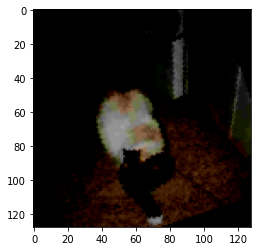

In [17]:
#チャネルラスト
img_permute = imgs[-1].permute(1, 2, 0)
plt.imshow(img_permute)

In [18]:
labels[0]

tensor(1)

In [19]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.classifier = nn.Linear(in_features=32*32*256, out_features=num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
        

In [20]:
model = CNN(2)
model.cuda()

CNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
  )
  (classifier): Linear(in_features=262144, out_features=2, bias=True)
)

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [22]:
num_epochs = 20
losses = []
accs = []
val_losses = []
val_accs = []
for epoch in range(num_epochs):
    running_loss = 0.0
    running_acc = 0.0
    for imgs, labels in train_dataloader:
        imgs = imgs.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output, labels)
        loss.backward()
        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        running_acc += torch.mean(pred.eq(labels).float())
        optimizer.step()
    running_loss /= len(train_dataloader)
    running_acc /= len(train_dataloader)
    losses.append(running_loss)
    accs.append(running_acc)
    #validation loop
    val_running_loss = 0.0
    val_running_acc = 0.0
    for val_imgs, val_labels in validation_dataloader:
        val_imgs = val_imgs.cuda()
        val_labels = val_labels.cuda()
        val_output = model(val_imgs)
        val_loss = criterion(val_output, val_labels)
        val_running_loss += val_loss.item()
        val_pred = torch.argmax(val_output, dim=1)
        val_running_acc += torch.mean(val_pred.eq(val_labels).float())
    val_running_loss /= len(validation_dataloader)
    val_running_acc /= len(validation_dataloader)
    val_losses.append(val_running_loss)
    val_accs.append(val_running_acc)
    print("epoch: {}, loss: {}, acc: {}, val loss: {}, val acc: {}".format(epoch, running_loss, running_acc, val_running_loss, val_running_acc))



epoch: 0, loss: 1.174688819050789, acc: 0.5325000286102295, val loss: 0.7140540182590485, val acc: 0.5600000023841858
epoch: 1, loss: 0.6607611089944839, acc: 0.6059999465942383, val loss: 0.7337845414876938, val acc: 0.5349999666213989
epoch: 2, loss: 0.6411451756954193, acc: 0.6190000176429749, val loss: 0.710767537355423, val acc: 0.5849999785423279
epoch: 3, loss: 0.5938941389322281, acc: 0.6879999041557312, val loss: 0.7682307362556458, val acc: 0.5450000166893005
epoch: 4, loss: 0.5823693186044693, acc: 0.700999915599823, val loss: 0.6939066648483276, val acc: 0.5550000071525574
epoch: 5, loss: 0.5608395934104919, acc: 0.7179999947547913, val loss: 0.7104206681251526, val acc: 0.574999988079071
epoch: 6, loss: 0.5522994250059128, acc: 0.7084999084472656, val loss: 0.669458419084549, val acc: 0.6150000095367432
epoch: 7, loss: 0.5513738125562668, acc: 0.7070000171661377, val loss: 0.7355671525001526, val acc: 0.5999999642372131
epoch: 8, loss: 0.5399425953626633, acc: 0.7215000987

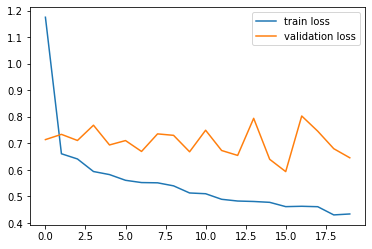

In [23]:
plt.plot(losses, label="train loss")
plt.plot(val_losses, label="validation loss")
plt.legend()

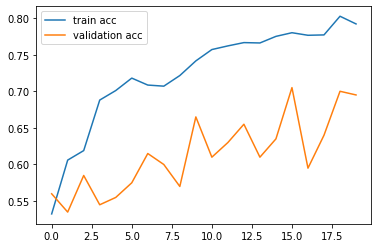

In [24]:
plt.plot(accs, label="train acc")
plt.plot(val_accs, label="validation acc")
plt.legend()